In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.regularizers import L1, L2
from tensorboard.plugins.hparams import api as hp
import tensorflow_probability as tfp
import wandb
from wandb.keras import WandbCallback
import datetime
import cv2
import io
import sklearn
import albumentations as A
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

2023-10-14 09:31:00.554455: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-14 09:31:00.554490: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-14 09:31:00.555610: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-14 09:31:00.654091: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## wandb install and login

In [3]:
#pip install wandb
#wandb login     #run these in terminal

In [4]:
wandb.init(
    project="malaria_Detection", entity="2lu"
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: 2lu. Use `wandb login --relogin` to force relogin


In [5]:
wandb.run

In [5]:
wandb.config = {
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 100,
    "BATCH_SIZE": 128,
    "DROPOUT_RATE": 0.0,
    "IM_SIZE": 224,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 128,
    "N_DENSE_2": 32
}

In [6]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

2023-10-14 09:31:20.507601: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-14 09:31:20.526958: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-14 09:31:20.527135: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [8]:
for data in dataset[0].take(1):
  print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


In [9]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [10]:
train_dataset, val_dataset, test_dataset = splits(dataset[0], 0.8, 0.1, 0.1)

In [11]:
for data in train_dataset.take(1):
  print(data)

(<tf.Tensor: shape=(151, 115, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


In [12]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/home/tulu/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood sme

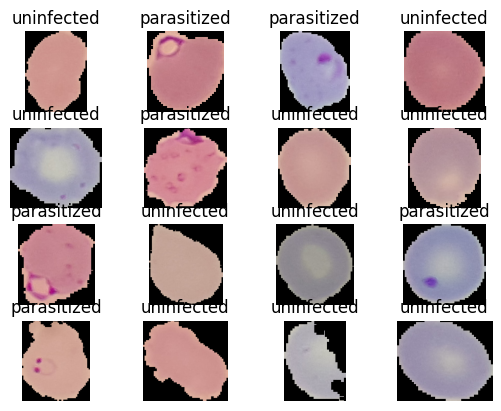

In [13]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label)) #here o means parasitized and 1 means uninfected
  plt.axis('off')

## Data Processing

In [20]:
def visualize(original, augmented):
    plt.subplot(1, 2, 1)
    plt.imshow(original)

    plt.subplot(1, 2, 2)
    plt.imshow(augmented)

In [21]:
original_image, label = next(iter(train_dataset))

In [387]:
augmented_image = tf.image.flip_left_right(original_image)

In [388]:
augmented_image = tf.image.flip_up_down(original_image)

In [389]:
augmented_image = tf.image.rot90(original_image)

In [390]:
augmented_image = tf.image.adjust_brightness(original_image, delta=0.3)

In [391]:
augmented_image = tf.image.random_saturation(original_image, lower=2, upper=12)

In [392]:
augmented_image = tf.image.central_crop(original_image, central_fraction=0.7)

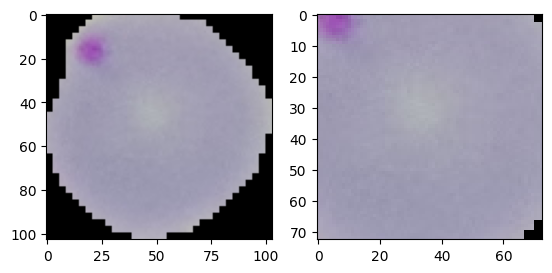

In [393]:
visualize(original_image, augmented_image)

In [14]:
#tf.image resize and rescale
IM_SIZE=224
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [12]:
# tf.keras.layer resize and rescale
resize_rescale_layers = tf.keras.Sequential([
    Resizing(IM_SIZE, IM_SIZE),
    Rescaling(1.0/255)
])

In [13]:
# tf.image augment
def augment(image, label):

    image, label = resize_rescale(image, label)
    image = tf.image.rot90(image)
    #image = tf.image.adjust_saturation(image, saturation_factor=0.3)
    image = tf.image.flip_left_right(image)
    return image, label

In [14]:
# tf.image is easy to work with but it can't be inserted in sequential layer directly. so we need to create a custom layer

class RotNinty(Layer):
    def __init__(self):
        super(RotNinty, self).__init__() 
    def call(self, image):
        return tf.image.rot90(image)

In [15]:
#tf.keras layer augment
augment_layers = tf.keras.Sequential([
    #RandomRotation(factor=(0.25, 0.2501)),
    RotNinty(),
    RandomFlip(mode='horizontal')
])

def augment_layer(image, label):
    return augment_layers(resize_rescale_layers(image), training=True), label

In [16]:
#test_dataset = test_dataset.map(resize_rescale_layers)

In [11]:
for image, label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], shape=(151, 115, 3), dtype=uint8) tf.Tensor(1, shape=(), dtype=int64)


In [15]:
BATCH_SIZE=32
train_dataset = (train_dataset
                 .shuffle(buffer_size=8, reshuffle_each_iteration=True)
                 .map(resize_rescale)
                 .batch(BATCH_SIZE)
                 .prefetch(tf.data.AUTOTUNE)
                )
                 

In [16]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [17]:
BATCH_SIZE=32
val_dataset = (
    val_dataset
    .shuffle(buffer_size=8, reshuffle_each_iteration=True)
    .map(resize_rescale)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [18]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [19]:
BATCH_SIZE=32
test_dataset = (
    test_dataset
    .map(resize_rescale)
    #.batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [20]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

## Mixup Data Augmentation

In [58]:
train_dataset_1 = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration = True).map(resize_rescale)
train_dataset_2 = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration = True).map(resize_rescale)

mixed_dataset = tf.data.Dataset.zip(train_dataset_1, train_dataset_2)
mixed_dataset

<_ZipDataset element_spec=((TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None)), (TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None)))>

In [59]:
def mixup(train_dataset_1, train_dataset_2):
    (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2
    
    lamda = tfp.distributions.Beta(0.2, 0.2)
    lamda = lamda.sample(1)[0]

    image = lamda*image_1 + (1-lamda)*image_2
    label = lamda*tf.cast(label_1, dtype=tf.float32) + (1-lamda)*tf.cast(label_2, dtype=tf.float32)
    return image, label

In [60]:
IM_SIZE=224

def box(lamda):
    r_x = tf.cast(tfp.distributions.Uniform(low=0, high=IM_SIZE).sample(1)[0], dtype=tf.int32)
    r_y = tf.cast(tfp.distributions.Uniform(low=0, high=IM_SIZE).sample(1)[0], dtype=tf.int32)

    r_w = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype=tf.int32)
    r_h = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype=tf.int32)

    r_x = tf.clip_by_value(r_x - r_w//2, 0, IM_SIZE) # x value of top left of clipped image
    r_y = tf.clip_by_value(r_y - r_h//2, 0, IM_SIZE) # y value of top left of clipped image

    x_b_r = tf.clip_by_value(r_x + r_w//2, 0, IM_SIZE)
    y_b_r = tf.clip_by_value(r_y + r_h//2, 0, IM_SIZE)

    r_w = x_b_r - r_x
    if(r_w == 0):
        r_w = 1

    r_h = y_b_r - r_y
    if r_h == 0:
        r_h = 1

    return r_y, r_x, r_h, r_w

In [63]:
def cutmix(train_dataset_1, train_dataset_2):
    (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

    lamda = tfp.distributions.Beta(0.2, 0.2)
    lamda = lamda.sample(1)[0]
    r_y, r_x, r_h, r_w = box(lamda)

    crop_2 = tf.image.crop_to_bounding_box(
        image=image_2, offset_height=r_y, 
        offset_width=r_x, target_height=r_h, target_width=r_w)
    padd_2 = tf.image.pad_to_bounding_box(crop_2, offset_height=r_y, offset_width=r_x, target_height=IM_SIZE, target_width=IM_SIZE)

    crop_1 = tf.image.crop_to_bounding_box(
        image=image_1, offset_height=r_y, 
        offset_width=r_x, target_height=r_h, target_width=r_w)
    padd_1 = tf.image.pad_to_bounding_box(crop_1, offset_height=r_y, offset_width=r_x, target_height=IM_SIZE, target_width=IM_SIZE)

    image = image_1-padd_1+padd_2

    lamda = tf.cast(1-(r_w*r_h)/(IM_SIZE*IM_SIZE), dtype=tf.float32)
    label = lamda*tf.cast(label_1, dtype=tf.float32) + (1-lamda)*tf.cast(label_2, dtype=tf.float32)

    return image, label
    

In [27]:
BATCH_SIZE=32
val_dataset = (
    val_dataset
    .map(resize_rescale)
    .batch(BATCH_SIZE)
    
)

In [64]:
BATCH_SIZE=32
train_dataset = (
    mixed_dataset
    .shuffle(buffer_size=8, reshuffle_each_iteration=True)
    #.map(mixup)
    .map(cutmix)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [65]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

tf.Tensor(
[1.3075972e-01 7.6753825e-01 0.0000000e+00 0.0000000e+00 2.2817683e-01
 1.0000000e+00 1.0000000e+00 0.0000000e+00 8.1632656e-01 7.5444436e-01
 2.4555564e-01 1.0000000e+00 1.6143179e-01 0.0000000e+00 0.0000000e+00
 9.9663186e-01 0.0000000e+00 6.7044020e-02 1.0000000e+00 1.0000000e+00
 1.0000000e+00 9.4886005e-02 1.0000000e+00 7.9691410e-05 8.3496094e-01
 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 2.4555564e-01
 0.0000000e+00 1.0000000e+00], shape=(32,), dtype=float32)


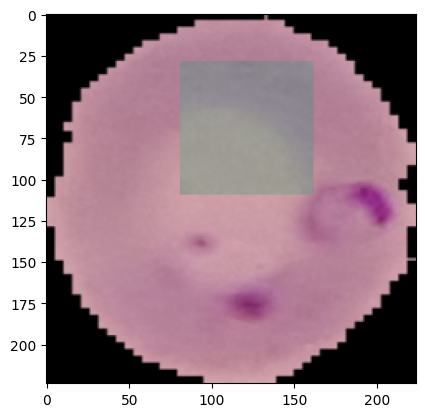

In [68]:
original_image, label = next(iter(train_dataset))
plt.imshow(original_image[0])
print(label)

### albumentations
third party tool for data augmentation

In [186]:
transforms = A.Compose([
    A.Resize(IM_SIZE, IM_SIZE),
    A.OneOf([A.HorizontalFlip(), A.VerticalFlip()], p=0.5),
    A.RandomRotate90(),
    A.RandomBrightnessContrast(brightness_limit=0.2,
                               contrast_limit=0.2,
                               always_apply=False, p=0.5),
    #A.CoarseDropout()
])

In [187]:
def aug_albument(image):
    data = {"image":image}
    image = transforms(**data)
    image = image["image"]
    image = tf.cast(image/255, tf.float32)

    return image

In [188]:
def process_data(image, label):
    aug_img = tf.numpy_function(func=aug_albument, inp=[image], Tout=tf.float32)
    return aug_img, label

In [18]:
BATCH_SIZE=32
train_dataset = (
    train_dataset
    .shuffle(buffer_size=8, reshuffle_each_iteration=True)
    .map(process_data)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
    )

In [19]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

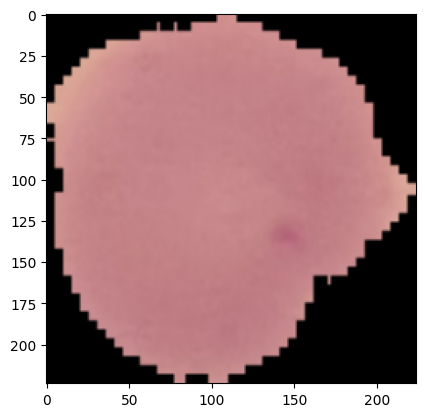

In [191]:
im, _ = next(iter(train_dataset))
plt.imshow(im[0])

In [192]:
plt.figure(figsize=(10, 10))

for i in range(0, 32):
    plt.subplot(8, 4, i+1)
    plt.imshow(im[i])

## Model create

In [21]:
wandb.config = {
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 3,
    "BATCH_SIZE": 128,
    "DROPOUT_RATE": 0.0,
    "IM_SIZE": 224,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 128,
    "N_DENSE_2": 32
}

In [22]:
CONFIGURATION = wandb.config
IM_SIZE= CONFIGURATION['IM_SIZE']
DROPOUT_RATE = CONFIGURATION['DROPOUT_RATE']
REGULARIZATION_RATE = CONFIGURATION['REGULARIZATION_RATE']
N_FILTERS = CONFIGURATION['N_FILTERS']
KERNEL_SIZE = CONFIGURATION['KERNEL_SIZE']
POOL_SIZE = CONFIGURATION['POOL_SIZE']
N_STRIDES = CONFIGURATION['N_STRIDES']

lenet_model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

    #resize_rescale_layers, # when using this layer choose batch size = 1 or error
    #augment_layers,

    Conv2D(filters=N_FILTERS, kernel_size=KERNEL_SIZE, strides=N_STRIDES, padding='valid', activation='relu', kernel_regularizer=L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D(pool_size=POOL_SIZE, strides=N_STRIDES*2),
    Dropout(rate=DROPOUT_RATE),

    Conv2D(filters=N_FILTERS*2, kernel_size=KERNEL_SIZE, strides=N_STRIDES, padding='valid', activation='relu', kernel_regularizer=L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D(pool_size=POOL_SIZE, strides=N_STRIDES*2),

    Flatten(),


    Dense(100, activation='relu', kernel_regularizer=L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    Dropout(rate=DROPOUT_RATE),
    
    Dense(10, activation='relu', kernel_regularizer=L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    
    Dense(1, activation='sigmoid'),
])

lenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 12)      660       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 12)      4

In [23]:
metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
           BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
LABELS = ['Parasitized', 'Uninfected']

In [29]:
lenet_model.compile(
    optimizer=Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
    loss = BinaryCrossentropy(),
    metrics = metrics
)

In [31]:
history = lenet_model.fit(train_dataset, validation_data=val_dataset, 
                          epochs=CONFIGURATION['N_EPOCHS'], verbose=1, 
                          callbacks=[LogImagesCallbackWandb()]) # image subscript not working

Epoch 1/3
  5/689 [..............................] - ETA: 24s - loss: 0.0995 - tp: 83.0000 - fp: 3.0000 - tn: 73.0000 - fn: 1.0000 - accuracy: 0.9750 - precision: 0.9651 - recall: 0.9881 - auc: 0.9901       WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0162s vs `on_train_batch_end` time: 0.0183s). Check your callbacks.


689/689 [==============================] - ETA: 0s - loss: 0.1737 - tp: 10464.0000 - fp: 805.0000 - tn: 10216.0000 - fn: 561.0000 - accuracy: 0.9380 - precision: 0.9286 - recall: 0.9491 - auc: 0.9791

: 

In [56]:
wandb.finish()

In [17]:
IM_SIZE=224

def model_tune(hparams):
    lenet_model = tf.keras.Sequential([
        InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

        #resize_rescale_layers, # when using this layer choose batch size = 1 or error
        #augment_layers,

        Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'), #, kernel_regularizer=L2(regularization_rate)),
        BatchNormalization(),
        MaxPool2D(pool_size=2, strides=2),
        Dropout(rate=hparams[HP_DROPOUT]),

        Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'), #kernel_regularizer=L2(regularization_rate)),
        BatchNormalization(),
        MaxPool2D(pool_size=2, strides=2),

        Flatten(),


        Dense(hparams[HP_NUM_UNITS_1], activation='relu', kernel_regularizer=L2(hparams[HP_REGULARIZATION_RATE])),
        BatchNormalization(),
        Dropout(rate=hparams[HP_DROPOUT]),
        
        Dense(hparams[HP_NUM_UNITS_2], activation='relu', kernel_regularizer=L2(hparams[HP_REGULARIZATION_RATE])),
        BatchNormalization(),
        
        Dense(1, activation='sigmoid'),
    ])

    lenet_model.compile(
        optimizer=Adam(learning_rate=hparams[HP_LEARNING_RATE]),
        loss = BinaryCrossentropy(),
        metrics = ['accuracy']
    )

    lenet_model.fit(val_dataset, epochs=1)
    _, accuracy = lenet_model.evaluate(val_dataset)

    return accuracy

### hyperparameter tuning

In [18]:
HP_NUM_UNITS_1 = hp.HParam('num_units_1', hp.Discrete([16, 32, 64, 128]))
HP_NUM_UNITS_2 = hp.HParam('num_units_2', hp.Discrete([16, 32, 64, 128]))
HP_DROPOUT = hp.HParam('droupout_rate', hp.Discrete([0.001, 0.01, 0.1]))
HP_REGULARIZATION_RATE = hp.HParam('regularization_rate', hp.Discrete([0.001, 0.01, 0.1]))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([1e-4, 1e-3]))

In [30]:
run_number = 0
for num_units_1 in HP_NUM_UNITS_1.domain.values:
    for num_units_2 in HP_NUM_UNITS_2.domain.values:
        for dropout_rate in HP_DROPOUT.domain.values:
            for regularization_rate in HP_REGULARIZATION_RATE.domain.values:
                for learning_rate in HP_LEARNING_RATE.domain.values:
                    
                    hparams = {
                        HP_NUM_UNITS_1: num_units_1,
                        HP_NUM_UNITS_2: num_units_2,
                        HP_REGULARIZATION_RATE: regularization_rate,
                        HP_LEARNING_RATE: learning_rate,
                        HP_DROPOUT: dropout_rate
                    }

                    file_writer = tf.summary.create_file_writer('logs/' + str(run_number))

                    with file_writer.as_default():
                        hp.hparams(hparams)
                        accuracy = model_tune(hparams)
                        tf.summary.scalar('accuracy', accuracy, step=run_number)
                    
                    print("For the run: {} our num_unit_1: {}, our num_unit_2: {}, our regularization: {}, our learning_rate: {}, our dropuout: {}"
                          .format(run_number, hparams[HP_NUM_UNITS_1], hparams[HP_NUM_UNITS_2], hparams[HP_REGULARIZATION_RATE], hparams[HP_LEARNING_RATE], hparams[HP_DROPOUT]))
                    run_number +=1

87/87 [==============================] - 5s 13ms/step - loss: 0.7779 - accuracy: 0.5074
For the run: 0 our num_unit_1: 16, our num_unit_2: 16, our regularization: 0.001, our learning_rate: 0.0001, our dropuout: 0.001
87/87 [==============================] - 4s 11ms/step - loss: 0.7604 - accuracy: 0.5154
For the run: 1 our num_unit_1: 16, our num_unit_2: 16, our regularization: 0.001, our learning_rate: 0.001, our dropuout: 0.001


2023-10-13 19:53:31.094527: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_10/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


87/87 [==============================] - 4s 12ms/step - loss: 1.1864 - accuracy: 0.5067
For the run: 2 our num_unit_1: 16, our num_unit_2: 16, our regularization: 0.01, our learning_rate: 0.0001, our dropuout: 0.001
87/87 [==============================] - 5s 12ms/step - loss: 1.0582 - accuracy: 0.5060
For the run: 3 our num_unit_1: 16, our num_unit_2: 16, our regularization: 0.01, our learning_rate: 0.001, our dropuout: 0.001
87/87 [==============================] - 5s 12ms/step - loss: 4.5768 - accuracy: 0.5053
For the run: 4 our num_unit_1: 16, our num_unit_2: 16, our regularization: 0.1, our learning_rate: 0.0001, our dropuout: 0.001
87/87 [==============================] - 5s 12ms/step - loss: 1.9872 - accuracy: 0.5060
For the run: 5 our num_unit_1: 16, our num_unit_2: 16, our regularization: 0.1, our learning_rate: 0.001, our dropuout: 0.001
87/87 [==============================] - 4s 12ms/step - loss: 0.7252 - accuracy: 0.5862
For the run: 6 our num_unit_1: 16, our num_unit_2: 1

2023-10-13 19:54:44.214486: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_15/dropout_30/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


87/87 [==============================] - 4s 12ms/step - loss: 0.7616 - accuracy: 0.4973
For the run: 7 our num_unit_1: 16, our num_unit_2: 16, our regularization: 0.001, our learning_rate: 0.001, our dropuout: 0.01
87/87 [==============================] - 5s 11ms/step - loss: 1.1654 - accuracy: 0.5064
For the run: 8 our num_unit_1: 16, our num_unit_2: 16, our regularization: 0.01, our learning_rate: 0.0001, our dropuout: 0.01
87/87 [==============================] - 5s 12ms/step - loss: 1.1688 - accuracy: 0.4962
For the run: 9 our num_unit_1: 16, our num_unit_2: 16, our regularization: 0.01, our learning_rate: 0.001, our dropuout: 0.01
87/87 [==============================] - 5s 15ms/step - loss: 4.3091 - accuracy: 0.5390
For the run: 10 our num_unit_1: 16, our num_unit_2: 16, our regularization: 0.1, our learning_rate: 0.0001, our dropuout: 0.01
87/87 [==============================] - 5s 12ms/step - loss: 2.2789 - accuracy: 0.5067
For the run: 11 our num_unit_1: 16, our num_unit_2: 1

2023-10-13 19:55:59.115902: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_20/dropout_40/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


87/87 [==============================] - 5s 12ms/step - loss: 0.7436 - accuracy: 0.4962
For the run: 12 our num_unit_1: 16, our num_unit_2: 16, our regularization: 0.001, our learning_rate: 0.0001, our dropuout: 0.1
87/87 [==============================] - 5s 16ms/step - loss: 0.7791 - accuracy: 0.4966
For the run: 13 our num_unit_1: 16, our num_unit_2: 16, our regularization: 0.001, our learning_rate: 0.001, our dropuout: 0.1
87/87 [==============================] - 5s 13ms/step - loss: 1.1801 - accuracy: 0.4962
For the run: 14 our num_unit_1: 16, our num_unit_2: 16, our regularization: 0.01, our learning_rate: 0.0001, our dropuout: 0.1
87/87 [==============================] - 5s 11ms/step - loss: 1.1307 - accuracy: 0.4711
For the run: 15 our num_unit_1: 16, our num_unit_2: 16, our regularization: 0.01, our learning_rate: 0.001, our dropuout: 0.1


2023-10-13 19:57:03.448929: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_24/dropout_48/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


87/87 [==============================] - 5s 15ms/step - loss: 4.9431 - accuracy: 0.5005
For the run: 16 our num_unit_1: 16, our num_unit_2: 16, our regularization: 0.1, our learning_rate: 0.0001, our dropuout: 0.1
87/87 [==============================] - 4s 11ms/step - loss: 2.0158 - accuracy: 0.4962
For the run: 17 our num_unit_1: 16, our num_unit_2: 16, our regularization: 0.1, our learning_rate: 0.001, our dropuout: 0.1
87/87 [==============================] - 4s 11ms/step - loss: 0.7379 - accuracy: 0.5858
For the run: 18 our num_unit_1: 16, our num_unit_2: 32, our regularization: 0.001, our learning_rate: 0.0001, our dropuout: 0.001
87/87 [==============================] - 5s 12ms/step - loss: 0.7704 - accuracy: 0.4991
For the run: 19 our num_unit_1: 16, our num_unit_2: 32, our regularization: 0.001, our learning_rate: 0.001, our dropuout: 0.001
87/87 [==============================] - 5s 13ms/step - loss: 1.3883 - accuracy: 0.5067
For the run: 20 our num_unit_1: 16, our num_unit_2

2023-10-13 19:58:18.986091: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_29/dropout_58/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


87/87 [==============================] - 5s 14ms/step - loss: 1.1138 - accuracy: 0.5902
For the run: 21 our num_unit_1: 16, our num_unit_2: 32, our regularization: 0.01, our learning_rate: 0.001, our dropuout: 0.001
87/87 [==============================] - 4s 12ms/step - loss: 4.8098 - accuracy: 0.5049
For the run: 22 our num_unit_1: 16, our num_unit_2: 32, our regularization: 0.1, our learning_rate: 0.0001, our dropuout: 0.001
87/87 [==============================] - 5s 12ms/step - loss: 2.1526 - accuracy: 0.5336
For the run: 23 our num_unit_1: 16, our num_unit_2: 32, our regularization: 0.1, our learning_rate: 0.001, our dropuout: 0.001
87/87 [==============================] - 5s 12ms/step - loss: 0.7408 - accuracy: 0.5906
For the run: 24 our num_unit_1: 16, our num_unit_2: 32, our regularization: 0.001, our learning_rate: 0.0001, our dropuout: 0.01


2023-10-13 19:59:21.146410: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_33/dropout_66/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


87/87 [==============================] - 5s 12ms/step - loss: 0.9230 - accuracy: 0.5038
For the run: 25 our num_unit_1: 16, our num_unit_2: 32, our regularization: 0.001, our learning_rate: 0.001, our dropuout: 0.01


KeyboardInterrupt: 

## Callbacks

In [403]:
class LossCallback(Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nFor Epoch Number {} has a loss of {}".format(epoch, logs["loss"]))
    def on_batch_end(self, batch, logs):
        print(f"\nFor batch number {batch} info {logs}")

### CSVLogger

In [404]:
csv_callback = CSVLogger(
    'logs.csv', separator=',', append=False # use append=True is the file exist and add new info in logs.csv
)

### Eary Stopping

In [405]:
es_callback = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=2, verbose=1, # patience menans upto no of epochs it will continue after getting no min val loss
    mode='auto', baseline=None, restore_best_weights=False
)

### Learning Rate Scheduler

In [48]:
def scheduler(epoch, lr):
    if epoch < 1:
        learning_rate = lr
    else:
        learning_rate =  lr * tf.math.exp(-0.1)
        learning_rate = learning_rate.numpy()
    with train_writer.as_default():
        tf.summary.scalar('Learning rate', data=learning_rate, step=epoch)
    return learning_rate

scheduler_callback = LearningRateScheduler(scheduler, verbose=1)

### ModelCheckPoint

In [407]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'checkpoints/',
    monitor = 'val_loss',
    verbose = 0,
    save_best_only = True,
    save_weights_only = False,
    mode = 'auto',
    save_freq='epoch'
)

### ReduceLearningRateOnPlateau

In [408]:
plateau_callback = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=2, verbose=1
)

### tensorboard

In [62]:
CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y-%h%m%s')
METRIC_DIR = './logs/' + CURRENT_TIME + '/metrics/'
print(METRIC_DIR)
train_writer = tf.summary.create_file_writer(METRIC_DIR)

./logs/121023-Oct101697113839/metrics/


In [63]:
LOG_DIR = "./logs/" + CURRENT_TIME
print(LOG_DIR)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR)

./logs/121023-Oct101697113839


### wandb

In [28]:
class LogImagesCallbackWandb(Callback):
    def on_epoch_end(self, epoch, logs):
        labels = []
        inp = []
        
        for x,y in test_dataset.as_numpy_iterator():
            labels.append(y)
            inp.append(x)

        #labels = np.array([i[0] for i in labels])
            
        predicted = lenet_model.predict(np.array(inp))[:, 0,...]

        print(predicted)

        
        wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        y_true=labels,
                        preds = predicted,
                        class_names=['parasitized', 'uninfected'])})
        

 for data augmentation go to https://www.tensorflow.org/api_docs/python/tf/image

## Model Training

In [10]:
metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
           BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

### custom Loss

#### without parameter

In [23]:
def custom_bce(y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred)

#### with parameter

In [26]:
FACTOR = 1
def custom_bce(FACTOR):
    def loss(y_true, y_pred):
        bce = BinaryCrossentropy()
        return bce(y_true, y_pred)*FACTOR

#### loss class

In [85]:
class CustomBCE(tf.keras.losses.Loss):
    def __init__(self, FACTOR):
        super(CustomBCE, self).__init__()
        self.FACTOR = FACTOR
    def call(self, y_true, y_pred):
        bce = BinaryCrossentropy()
        return bce(y_true, y_pred)*FACTOR

### Custom Accuracy

#### without parameter

In [149]:
def custom_accuracy(y_true, y_pred):
    return binary_accuracy(y_true, y_pred)
    

#### with parameter

In [163]:
FACTOR=1
def custom_accuracy_par(FACTOR):
    def accuracy(y_true, y_pred):
        return binary_accuracy(y_true, y_pred)*FACTOR
    return accuracy

#### class

In [29]:
#here BinaryAccuracy not working
class CustomAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='Custom_Accuracy', FACTOR=1):
        super(CustomAccuracy, self).__init__()
        self.FACTOR = FACTOR
        self.accuracy = self.add_weight(name=name, initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        output = binary_accuracy(tf.cast(y_true, dtype=tf.float32), y_pred)*self.FACTOR
        print(output)
        self.accuracy.assign(output)

    def result(self):
        return self.accuracy
    
    def reset_state(self):
        self.accuracy.assign(0.)
    

In [183]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

### Custom fit

In [20]:
OPTIMIZER = Adam(learning_rate=0.01)
METRIC = BinaryAccuracy()
METRIC_VAL = BinaryAccuracy()
EPOCHS = 3

In [60]:
@tf.function
def training_block(model, X_batch, y_batch, loss_fn, METRIC):
    with tf.GradientTape() as recorder:
        y_pred = model(X_batch, training=True)
        loss = loss_fn(y_batch, y_pred)
        
    partial_derivatives = recorder.gradient(loss, lenet_model.trainable_weights)

    OPTIMIZER.apply_gradients(zip(partial_derivatives, lenet_model.trainable_weights))

    METRIC.update_state(y_batch, y_pred)

    return loss

In [61]:
@tf.function
def validation_block(model, x_batch_val, y_batch_val, loss_fn, METRIC_VAL):
    y_pred_val = model(x_batch_val, training=False)
    loss_val = loss_fn(y_batch_val, y_pred_val)
    METRIC_VAL.update_state(y_batch_val, y_pred_val)
    return loss_val

In [62]:

def neuralearn(model, loss_function, METRIC, METRIC_VAL, EPOCHS, train_dataset, val_dataset):
    for epoch in range(EPOCHS):
        print(f"Training starts for epoch {epoch}")
        for step, (X_batch, y_batch) in enumerate(train_dataset):
            loss = training_block(model, X_batch, y_batch, loss_function, METRIC)
            if(step%300==0):
                print(f"Training loss = {loss}")
        print(f"The accuracy is: {METRIC.result()}")
        METRIC.reset_states()

        for (x_batch_val, y_batch_val) in val_dataset:
            loss_val = validation_block(model, x_batch_val, y_batch_val, loss_function, METRIC_VAL)

        print(f"Validation error: {loss_val}")

In [64]:
neuralearn(lenet_model, custom_bce, METRIC, METRIC_VAL, EPOCHS, train_dataset, val_dataset)

NameError: name 'neuralearn' is not defined

### readymade model train

In [21]:
lenet_model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss = BinaryCrossentropy(),
    metrics = metrics,
    run_eagerly=True
)

Epoch 1/3


2023-10-12 18:58:05.747746: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-12 18:58:08.902465: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55886808be80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-12 18:58:08.902502: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2023-10-12 18:58:08.909549: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-12 18:58:09.013112: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


689/689 [==============================] - ETA: 0s - loss: 3.9650 - tp: 6860.0000 - fp: 3928.0000 - tn: 7093.0000 - fn: 4165.0000 - accuracy: 0.6329 - precision: 0.6359 - recall: 0.6222 - auc: 0.6751

2023-10-12 18:59:51.802706: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1660022784 exceeds 10% of free system memory.
2023-10-12 18:59:52.866979: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1660022784 exceeds 10% of free system memory.


87/87 [==============================] - 1s 17ms/step
[[1285  106]
 [1030  336]]


ValueError: Tensor  must have rank 4.  Received rank 3, shape (800, 800, 3)

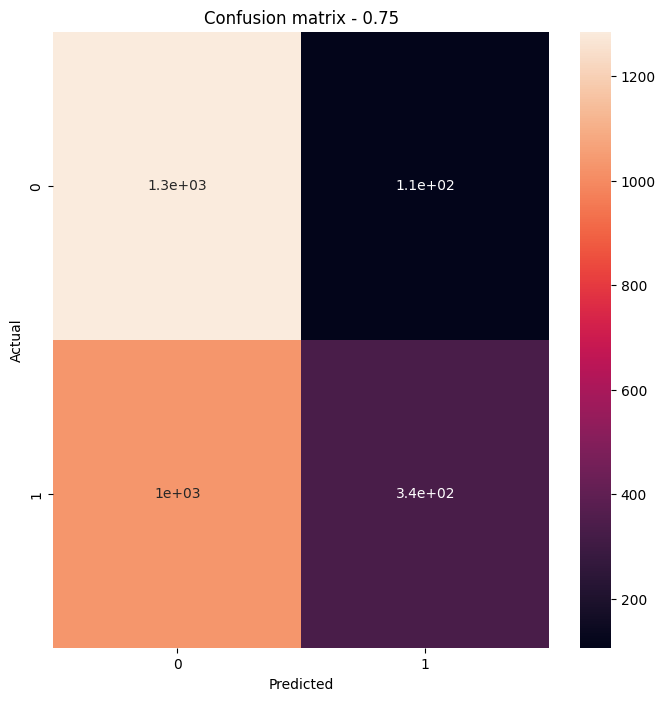

In [22]:
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs=3, verbose=1, callbacks=[LogImagesCallback()])

## Cutmix data augmentation
here we cut a part of a image and paste it in another image

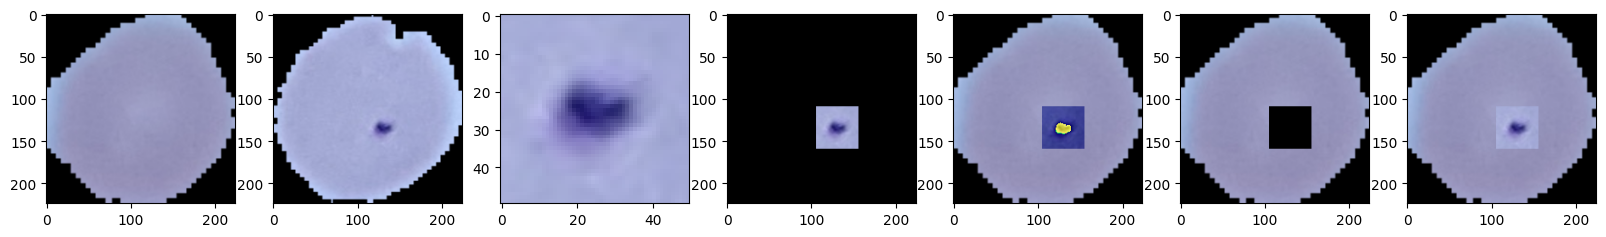

In [96]:
IM_SIZE=224
plt.figure(figsize=(20, 20))
plt.subplot(1, 7, 1)
image_1 = cv2.resize(cv2.imread('uninf_cell.png'), (IM_SIZE, IM_SIZE))
plt.imshow(image_1)

plt.subplot(1, 7, 2)
image_2 = cv2.resize(cv2.imread('inf_cell.png'), (IM_SIZE, IM_SIZE))
plt.imshow(image_2)

plt.subplot(1, 7, 3)
crop_2 = tf.image.crop_to_bounding_box(
    image=image_2, offset_height=110, 
    offset_width=105, target_height=50, target_width=50)
plt.imshow(crop_2)

plt.subplot(1, 7, 4)
padd_2 = tf.image.pad_to_bounding_box(crop_2, offset_height=110, offset_width=105, target_height=IM_SIZE, target_width=IM_SIZE)
plt.imshow(padd_2)

plt.subplot(1, 7, 5)
image_3 = image_1+padd_2
plt.imshow(image_3)
# above process paste the cropped image over original but we have to first crop thar portion of the original

plt.subplot(1, 7, 6)
crop_1 = tf.image.crop_to_bounding_box(
    image=image_1, offset_height=110, 
    offset_width=105, target_height=50, target_width=50)
padd_1 = tf.image.pad_to_bounding_box(crop_1, offset_height=110, offset_width=105, target_height=IM_SIZE, target_width=IM_SIZE)

image_4 = image_1 - padd_1
plt.imshow(image_4)

plt.subplot(1, 7, 7)
image_5 = image_4 + padd_2
plt.imshow(image_5)

## Visualization

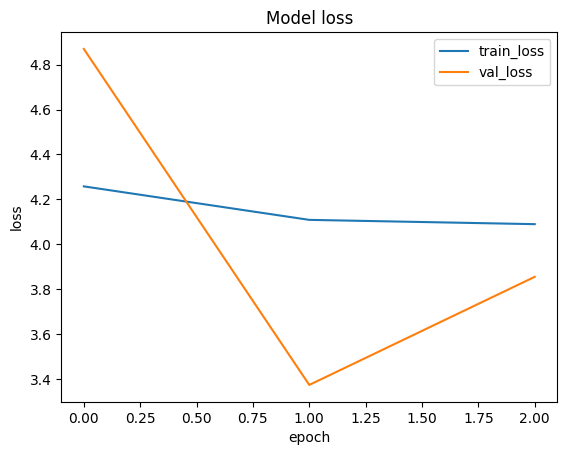

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [41]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Acuuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

### tensorboard

In [32]:
%load_ext tensorboard

we can use tensorboard profiling to get better understanding and optimization of out model

In [34]:
tensorboard --logdir=logs --port 5000 #use exactly this command otherwise not working

Reusing TensorBoard on port 5000 (pid 85705), started 0:00:17 ago. (Use '!kill 85705' to kill it.)

### Visualising Confusion Matrix

In [88]:
len(test_dataset)

2757

In [86]:
labels = []
inp = []

for x,y in test_dataset.as_numpy_iterator():
    labels.append(y)
    inp.append(x)

In [87]:
print(np.array(inp).shape)

(2757, 224, 224, 3)


In [ ]:
predicted = lenet_model.predict(np.array(inp))
print(predicted[:,0].shape)


In [ ]:
threshold = 0.75

cm = confusion_matrix(labels, predicted>threshold)
print(cm)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True)
plt.title("Confusion matrix - {}".format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [20]:
#currently i can't make it work
class LogImagesCallback(Callback):
    def on_epoch_end(self, epoch, logs):
        labels = []
        inp = []
        
        for x,y in test_dataset.as_numpy_iterator():
            labels.append(y)
            inp.append(x)
            
        predicted = lenet_model.predict(np.array(inp))
        threshold = 0.75

        cm = confusion_matrix(labels, predicted>threshold)
        print(cm)
        
        plt.figure(figsize=(8, 8))
        sns.heatmap(cm, annot=True)
        plt.title("Confusion matrix - {}".format(threshold))
        plt.ylabel('Actual')
        plt.xlabel('Predicted')

        buffer = io.BytesIO()
        plt.savefig(buffer, format='png')

        image = tf.image.decode_png(buffer.getvalue(), channels=3)

        CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y-%h%m%s')
        IMAGE_DIR = './logs/' + CURRENT_TIME + '/images'
        image_writer = tf.summary.create_file_writer(IMAGE_DIR)

        with image_writer.as_default():
            tf.summary.image("Training data", image, step=epoch)


### ROC curve

In [ ]:
fp, tp, thresholds = roc_curve(labels, predicted)
plt.figure(figsize=(15, 20))
plt.plot(fp, tp)
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.grid()

skip = 10
for i in range(0, len(thresholds), skip):
    plt.text(fp[i], tp[i], thresholds[i])

plt.show()

## Model evaluation

In [ ]:
test_dataset = test_dataset.batch(1)
test_dataset

In [ ]:
lenet_model.evaluate(test_dataset)

In [ ]:
def parasite_or_not(x):
  if x<0.5:
    return "P"
  else:
    return "U"

In [ ]:
parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0])

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(lenet_model.predict(image, verbose=0)[0][0])))
  plt.axis('off')

### Tensorflow execution Mode

In [187]:
@tf.function
def fun(name):
    print(name)
    return name

_ = fun('sudip')
_= fun('sudip')

sudip


In [188]:
tf.config.run_functions_eagerly(True)
_ = fun('sudip')
_ = fun('sudip')

sudip
sudip


In [28]:
w = tf.summary.create_file_writer('test/logs')
with w.as_default():
  image1 = tf.random.uniform(shape=[8, 8, 1])
  image2 = tf.random.uniform(shape=[8, 8, 1])
  tf.summary.image("grayscale_noise", [image1, image2], step=0)
